In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Case Study - Text classification for SMS spam detection

We first load the text data from the `datasets` directory that should be located in your notebooks directory, which we created by running the `fetch_data.py` script from the top level of the GitHub repository.

Furthermore, we perform some simple preprocessing and split the data array into two parts:

1. `text`: A list of lists, where each sublists contains the contents of our emails
2. `y`: our SPAM vs HAM labels stored in binary; a 1 represents a spam message, and a 0 represnts a ham (non-spam) message. 

In [2]:
import os

with open(os.path.join("datasets", "smsspam", "SMSSpamCollection")) as f:
    lines = [line.strip().split("\t") for line in f.readlines()]

text = [x[1] for x in lines]
y = [int(x[0] == "spam") for x in lines]

In [7]:
text[:10]

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, $1.50 to rcv",
 'Even my brother is not like to speak with me. They treat me like aids patent.',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'WINNER!! As a valued network customer you have been selected to receivea $900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had you

In [17]:
len(text)

5574

In [8]:
y[:10]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1]

In [9]:
print('Number of ham and spam messages:', np.bincount(y))

Number of ham and spam messages: [4827  747]


In [10]:
type(text)

list

In [11]:
type(y)

list

In [20]:
fraction_spam = np.mean(y)
fraction_spam

0.1340150699677072

Next, we split our dataset into 2 parts, the test and training dataset:

In [18]:
from sklearn.model_selection import train_test_split

text_train, text_test, y_train, y_test = train_test_split(text, y, 
                                                          random_state=42,
                                                          test_size=0.25,
                                                          stratify=y)
len(text_train)

4180

Now, we use the CountVectorizer to parse the text data into a bag-of-words model.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

print('CountVectorizer defaults')
CountVectorizer()

CountVectorizer defaults


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(text_train)

X_train = vectorizer.transform(text_train)
X_test = vectorizer.transform(text_test)

In [15]:
print(len(vectorizer.vocabulary_))

7453


In [21]:
X_train.shape

(4180, 7453)

In [22]:
print(vectorizer.get_feature_names()[:20])

['00', '000', '000pes', '008704050406', '0089', '01223585236', '01223585334', '02', '0207', '02072069400', '02073162414', '02085076972', '021', '03', '04', '0430', '05', '050703', '0578', '06']


--> The feature names are sorted alphabetically.

In [25]:
print(vectorizer.get_feature_names()[2000:2020])

['crammed', 'cramps', 'crap', 'crash', 'crashed', 'crashing', 'crave', 'craving', 'craziest', 'crazy', 'crazyin', 'crckt', 'cream', 'created', 'creative', 'credit', 'credited', 'credits', 'creep', 'creepy']


In [26]:
print(X_train.shape)
print(X_test.shape)

(4180, 7453)
(1394, 7453)


### Training a Classifier on Text Features

We can now train a classifier, for instance a logistic regression classifier, which is a fast baseline for text classification tasks:

In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
clf.fit(X_train, y_train)

C:\Python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

We can now evaluate the classifier on the testing set. Let's first use the built-in score function, which is the rate of correct classification in the test set:

In [29]:
clf.score(X_test, y_test)

0.9849354375896701

We can also compute the score on the training set to see how well we do there:

In [30]:
clf.score(X_train, y_train)

0.9983253588516746

# Visualizing important features

In [31]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["tab:orange" if c < 0 else "tab:blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 2 * n_top_features + 1), feature_names[interesting_coefficients], rotation=60, ha="right");

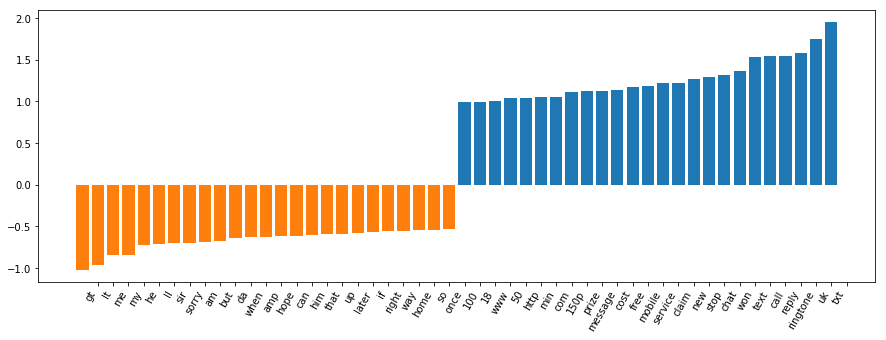

In [32]:
visualize_coefficients(clf, vectorizer.get_feature_names())

In [42]:
vectorizer = CountVectorizer(min_df=2)
vectorizer.fit(text_train)

X_train = vectorizer.transform(text_train)
X_test = vectorizer.transform(text_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9954545454545455
0.9835007173601148


In [43]:
len(vectorizer.get_feature_names())

3439

In [44]:
print(vectorizer.get_feature_names()[:20])

['00', '000', '01223585334', '02', '0207', '02073162414', '03', '04', '05', '0578', '06', '07', '07123456789', '07781482378', '07821230901', '07xxxxxxxxx', '0800', '08000839402', '08000930705', '08000938767']


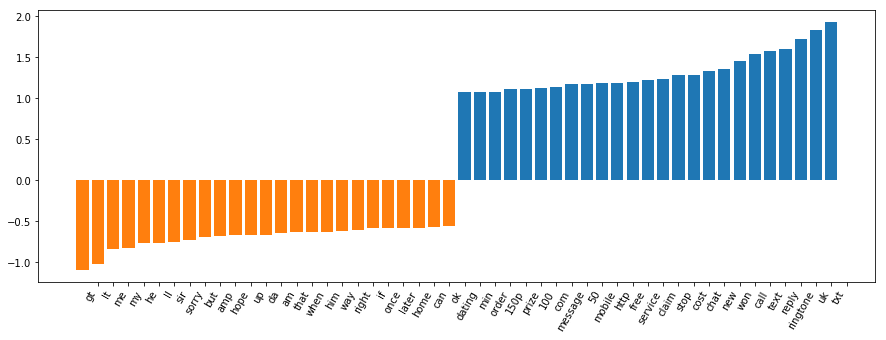

In [45]:
visualize_coefficients(clf, vectorizer.get_feature_names())

<img src="figures/supervised_scikit_learn.png" width="80%">

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Use TfidfVectorizer instead of CountVectorizer. Are the results better? How are the coefficients different?
      </li>
      <li>
      Change the parameters min_df and ngram_range of the TfidfVectorizer and CountVectorizer. How does that change the important features?
      </li>
    </ul>
</div>

0.974401913875598
0.9727403156384505


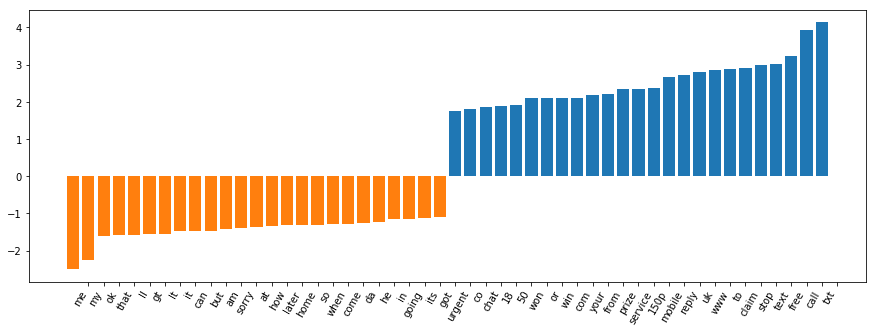

In [48]:
# %load solutions/12A_tfidf.py
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(text_train)

X_train = vectorizer.transform(text_train)
X_test = vectorizer.transform(text_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

visualize_coefficients(clf, vectorizer.get_feature_names())


0.9942583732057416
0.9849354375896701
0.9818181818181818
0.9813486370157819


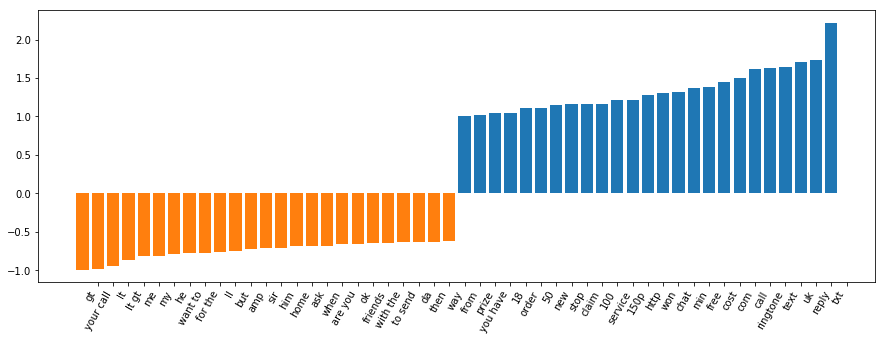

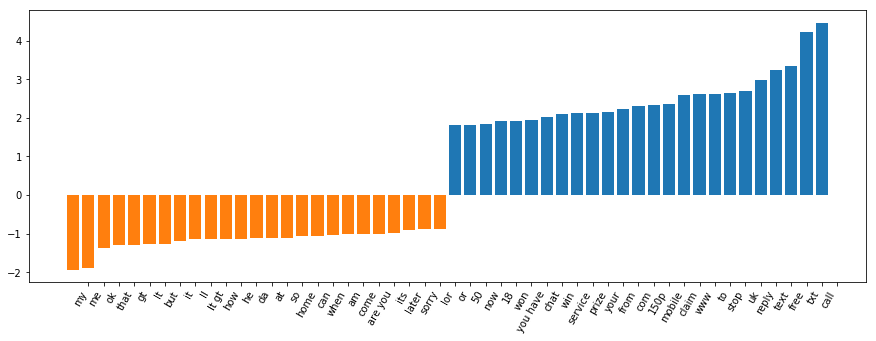

In [50]:
# %load solutions/12B_vectorizer_params.py
# CountVectorizer
vectorizer = CountVectorizer(min_df=10, ngram_range=(1, 3))
vectorizer.fit(text_train)

X_train = vectorizer.transform(text_train)
X_test = vectorizer.transform(text_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)

visualize_coefficients(clf, vectorizer.get_feature_names())

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))


# TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 3))
vectorizer.fit(text_train)

X_train = vectorizer.transform(text_train)
X_test = vectorizer.transform(text_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)

visualize_coefficients(clf, vectorizer.get_feature_names())

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))